In [20]:
import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
def generate_property():
    # each node contain such property:
    #          E/I, blocked_in_stat, I_extern_Input, sub_block_idx, C, T_ref, g_Li, V_L, V_th, V_reset, g_ui, V_ui, tao_ui
    #   size:  1,   1,               1,                1,           1, 1,     1,    1,   1,    1,       4     4,    4
    #   dtype: b,   b,               f,                i,           f, f,     f,    f,   f,    f,       f,    f,    f
    # b means bool(although storage as float), f means float.

    property = np.zeros([1, 22], dtype=np.float32)
    E_thresh = 1
    property[:, 0] = 1

    property[:, 1] = 0

    property[:, 2] = 0

    property[:, 3] = 0
    property[:, 4] = 1
    property[:, 5] = 5
    property[:, 6] = 0.001
    property[:, 7] = -75
    property[:, 8] = -50
    property[:, 9] = -65

#     g_ui =np.array([5/275, 5/4000, 3/30, 3/730])
    g_ui =np.array([10/825, 5/6000, 3/60, 3/1460])
    g_ui =g_ui if isinstance(g_ui, np.ndarray) else np.array(g_ui)
    property[:, 10:14] = g_ui
    
    V_ui = np.array([0, 0, -70, -100])
    V_ui =  V_ui  if isinstance(V_ui, np.ndarray) else np.array(V_ui)
    property[:, 14:18] = V_ui
    
    tao_ui =np.array ([2, 40, 10, 50])
#     tao_ui =np.array ([1, 20, 5, 25])
    tao_ui = tao_ui if isinstance(tao_ui, np.ndarray) else np.array(tao_ui)

    property[:, 18:22] = tao_ui

    return property


In [3]:
property=generate_property()
print(property)

[[ 1.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   1.0000000e+00  5.0000000e+00  1.0000000e-03 -7.5000000e+01
  -5.0000000e+01 -6.5000000e+01  1.2121212e-02  8.3333335e-04
   5.0000001e-02  2.0547945e-03  0.0000000e+00  0.0000000e+00
  -7.0000000e+01 -1.0000000e+02  2.0000000e+00  4.0000000e+01
   1.0000000e+01  5.0000000e+01]]


In [4]:
print(property.shape)

(1, 22)


In [5]:
torch.manual_seed(2020)
ranadj=torch.rand(10,2)
print(ranadj)

tensor([[0.4869, 0.1052],
        [0.5883, 0.1161],
        [0.4949, 0.2824],
        [0.5899, 0.8105],
        [0.2512, 0.6307],
        [0.5403, 0.8033],
        [0.7781, 0.4966],
        [0.8888, 0.5570],
        [0.7127, 0.0339],
        [0.1151, 0.8780]])


In [6]:
with open('ranadj.pickle','wb') as f:
    pickle.dump(ranadj,f)

In [7]:
print(ranadj[0,0])

tensor(0.4869)


In [8]:
A=np.zeros([4,600001])
for o in range(1):
    bos1=np.random.exponential(30,24000)
    bos1_1=bos1.astype(np.int32)
    bos2=np.random.exponential(30,24000)
    bos2_2=bos2.astype(np.int32)
    bos3=np.random.exponential(30,24000)
    bos3_3=bos3.astype(np.int32)
    bos4=np.random.exponential(30,24000)
    bos4_4=bos4.astype(np.int32)
    bos5=np.random.exponential(30,24000)
    bos5_5=bos5.astype(np.int32)
    bos6=np.random.exponential(30,24000)
    bos6_6=bos6.astype(np.int32)
    bos7=np.random.exponential(30,24000)
    bos7_7=bos7.astype(np.int32)
    bos8=np.random.exponential(30,24000)
    bos8_8=bos8.astype(np.int32)
    bos9=np.random.exponential(30,24000)
    bos9_9=bos9.astype(np.int32)
    bos10=np.random.exponential(30,24000)
    bos10_10=bos10.astype(np.int32)

    bos=np.concatenate((bos1_1,bos2_2,bos3_3,bos4_4,bos5_5,bos6_6,bos7_7,bos8_8,bos9_9,bos10_10),axis=0)
    bos=bos.reshape((10,24000))
    bosA=np.zeros([10,600001])
    print(bos.shape)
    print(np.sum(bos,axis=1))
    for k in range(10):
        j=0
        i=bos[k][j]
        while i<600001:
            bosA[k][i]=1
            j=j+1
            i=i+bos[k][j]
            
    for p in range(600001):
        A[0,p]=bosA[0,p]*ranadj[0,0]+bosA[1,p]*ranadj[1,0]+bosA[2,p]*ranadj[2,0]+bosA[3,p]*ranadj[3,0]+bosA[4,p]*ranadj[4,0]+bosA[5,p]*ranadj[5,0]+bosA[6,p]*ranadj[6,0]+bosA[7,p]*ranadj[7,0]
        A[1,p]=bosA[0,p]*ranadj[0,1]+bosA[1,p]*ranadj[1,1]+bosA[2,p]*ranadj[2,1]+bosA[3,p]*ranadj[3,1]+bosA[4,p]*ranadj[4,1]+bosA[5,p]*ranadj[5,1]+bosA[6,p]*ranadj[6,1]+bosA[7,p]*ranadj[7,1]
        A[2,p]=bosA[8,p]*ranadj[8,0]+bosA[9,p]*ranadj[9,0]
        A[3,p]=bosA[8,p]*ranadj[8,1]+bosA[9,p]*ranadj[9,1]

(10, 24000)
[713580 712163 706748 704451 717184 705646 708702 706556 710196 704140]


In [9]:
print(A.shape)

(4, 600001)


In [10]:
with open('Abos.pickle','wb') as f:
    pickle.dump(A,f)

In [11]:
t1=np.random.exponential(30,10000)
t2=t1.astype(np.int16)
su=np.sum(t2)
print(su)

291914


In [12]:
print(A[0,100:200])

[0.88879073 0.77814674 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.25119442 0.         0.77814674 0.         0.         0.
 0.         0.         0.54029256 0.49485415 0.4868679  0.
 0.         0.         0.         0.         0.77814674 0.
 0.         0.         0.         0.77814674 0.         0.
 0.77814674 0.88879073 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.58994275
 0.         0.         0.4868679  0.58833712 0.         0.
 0.         0.         0.         0.         0.58833712 0.
 0.         0.54029256 0.88879073 0.58833712 1.31843925 0.
 0.         0.         0.         0.4868679  0.         0.
 0.         0.         0.         0.25119442 0.         0.
 0.58833712 0.         0.         0.88879073 0.         0.
 0.         0.         0.         0.77814674 0.         0.
 0.         0.4868679  0.         0.        ]


In [13]:
# print(A[0,:])

In [14]:
import random

In [15]:
for i in range(1,11):
    x = random.expovariate(15) # rate = 15 arrivals per second
    print(x)

0.027748807033364006
0.007188874573861022
0.009257340607886104
0.07738362794380733
0.03789254988345982
0.011791565958861307
0.010662153563510173
0.05906557999829784
0.04528135190161398
0.12291369283152291


In [16]:
t1=np.random.exponential(100/3,100)
# print(t1)


In [17]:
# print(t1)

In [18]:
bos10= np.random.poisson(lam=0.03,size=100)
print(bos10)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


(array([38., 24., 13.,  8.,  5.,  4.,  2.,  2.,  2.,  0.,  1.,  0.,  1.]),
 array([  0.43039368,  12.60017604,  24.7699584 ,  36.93974076,
         49.10952312,  61.27930548,  73.44908784,  85.61887021,
         97.78865257, 109.95843493, 122.12821729, 134.29799965,
        146.46778201, 158.63756437]),
 <BarContainer object of 13 artists>)

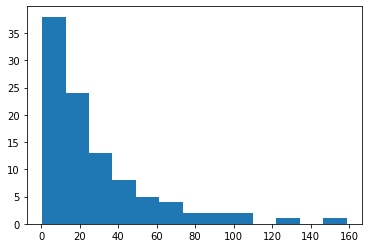

In [21]:
plt.hist(x=t1,bins='auto')

In [22]:
class block:
    def __init__(self, node_property,bosong,delta_t=1):
        # A block is a set of spliking neurals with inner full connections, we consider 4 connections:
        # AMPA, NMDA, GABAa and GABAb
        # shape note:
        #
        # N: numbers of neural cells
        # K: connections kind, = 4 (AMPA, NMDA, GABAa and GABAb)
     
        N = 1
        K = 4
        self.bosong=bosong
        
        self.delta_t = delta_t

        self.I_extern_Input = torch.tensor(node_property[:, 2]) # extern_input index , shape[K]
        self.V_ui =torch.tensor(node_property[:, 14:18].reshape([4,1]))  # AMPA, NMDA, GABAa and GABAb potential, shape [K, N]
        self.tau_ui = torch.tensor(node_property[:, 18:22].reshape([4,1]))# shape [K, N]
        self.g_ui = torch.tensor(node_property[:, 10:14].reshape([4,1])) # shape [K, N]
        self.g_Li = torch.tensor(node_property[:, 6])  # shape [N]
        self.V_L = torch.tensor(node_property[:, 7])  # shape [N]
        self.C = torch.tensor(node_property[:, 4])   # shape [N]
        self.sub_idx = torch.tensor(node_property[:, 3]) # shape [N]
        self.V_th = torch.tensor(node_property[:, 8])  # shape [N]
        self.V_reset = torch.tensor(node_property[:, 9]) # shape [N]
        self.T_ref = torch.tensor(node_property[:, 5]) # shape [N]

        self.t_ik_last = torch.zeros([N]) # shape [N]
        self.V_i = torch.ones([N]) * (self.V_th + self.V_reset)/2  # membrane potential, shape: [N]
        self.J_ui = torch.zeros([K, N])  # shape [K, N]
        self.t = torch.tensor(0.)  # scalar

        self.update_I_syn()


    def update_J_ui(self, delta_t):
        # active shape: [N], dtype bool
        # t is a scalar
        g=np.array(self.t)
        self.J_ui = self.J_ui * torch.exp(-delta_t / self.tau_ui) #shape:4*1
        bosong1= self.bosong[:,int(g)]####产生01的泊松分布
        J_ui_activate_part = torch.tensor(bosong1).view(4,1) # !!! this part can be sparse.#####输入一个泊松分布
        self.J_ui += J_ui_activate_part
        pass


    def update_I_syn(self):
        self.I_ui = self.g_ui * (self.V_ui - self.V_i) * self.J_ui
        # [K, N]            [K, N] - [K, 1]
        self.I_syn = self.I_ui.sum(dim=0)
        pass

    def update_Vi(self, delta_t):
        main_part = -self.g_Li * (self.V_i - self.V_L)
        C_diff_Vi = main_part + self.I_syn + self.I_extern_Input
        delta_Vi = delta_t / self.C * C_diff_Vi

        Vi_normal = self.V_i + delta_Vi

        is_not_saturated = (self.t >= self.t_ik_last + self.T_ref)
        V_i = torch.where(is_not_saturated, Vi_normal, self.V_reset)
        #print(is_not_saturated.sum())
        active = (V_i >= self.V_th)
        self.V_i = torch.min(V_i, self.V_th)
        return active

    def update_t_ik_last(self, active):
        self.t_ik_last = torch.where(active, self.t, self.t_ik_last)

    def run(self, noise_rate=0.01, isolated=False):
        self.t += self.delta_t
        self.active = self.update_Vi(self.delta_t)###处于激活/不激活
        
        self.update_J_ui(self.delta_t)
        self.update_I_syn()
        self.update_t_ik_last(self.active)

#         mean_Vi = []
#         sum_activate = []
#         for i in range(self.sub_idx.max().int() + 1):
#             mean_Vi.append(self.V_i[self.sub_idx == i].mean())
#             sum_activate.append(self.active[self.sub_idx == i].float().sum())
        return self.V_i,self.t

#         return torch.stack(sum_activate), torch.stack(mean_Vi)



In [23]:
def main():
    x_out=[]
    y_out=np.zeros(600000)
    b=block(property,A)
    for i in range(600000):
        x,y=b.run()
#         print("x:",x)
#         print("y:",y)
        x_out.append(x)
        y=np.array(y)
        y_out[i]=y
    return x_out,y_out

In [24]:
if __name__=="__main__":
    yy,tt1=main()

In [25]:
yy1=np.array(yy)
tt1=np.array(tt1)
print(yy1.shape)

(600000,)


In [26]:
import matplotlib.pyplot as plt

In [27]:
tt1=np.linspace(1,600000,600000)

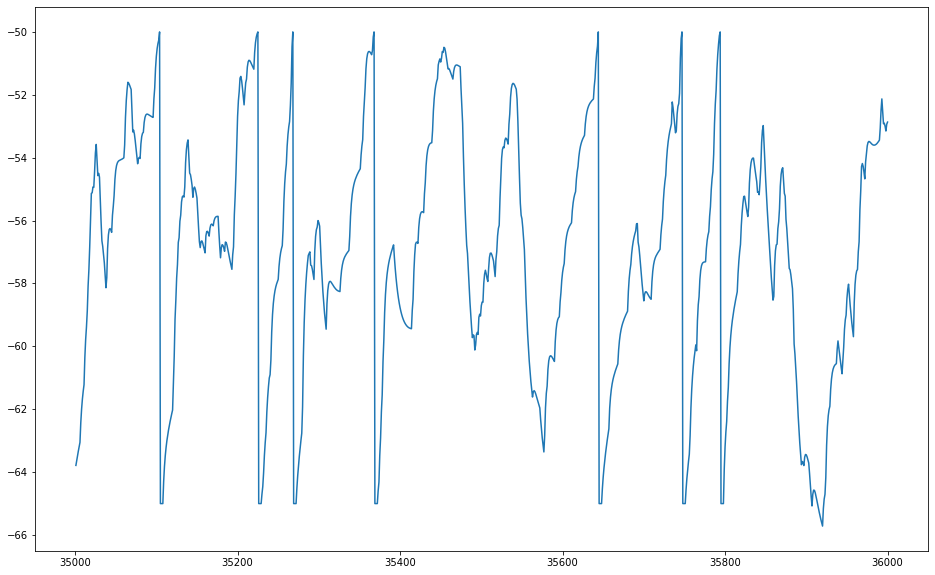

In [28]:
pop=35
plt.subplots(figsize=(16, 10))
plt.plot(tt1[pop*1000:pop*1000+1000],yy1[pop*1000:pop*1000+1000])  #画图
plt.show()#loss函数图

In [27]:
results = [tt1, yy1]
with open('small_cell.pickle','wb') as f:
    pickle.dump(results,f)

In [28]:
with open('small_cell.pickle','rb+') as f:
    a2019,b2019=pickle.load(f)

In [29]:
print(a2019.shape,a2019[1:20])

(600000,) [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20.]


In [32]:
print(b2019.shape,b2019[0:300])

(200000,) [-65.       -65.       -65.       -65.       -64.60482  -64.36535
 -64.21954  -64.130356 -64.075516 -64.04159  -64.020454 -63.623764
 -63.382717 -63.23531  -63.388138 -63.5469   -63.80425  -64.04267
 -64.26154  -64.668564 -65.01997  -65.32521  -65.59196  -65.826454
 -66.03381  -66.218216 -66.38311  -66.53134  -66.665276 -66.30502
 -66.26808  -66.32576  -65.85921  -65.277855 -65.03803  -64.98752
 -65.039696 -65.144966 -65.36584  -65.587265 -65.80173  -66.00567
 -66.19777  -66.37792  -66.54665  -66.04955  -65.3298   -64.957924
 -64.78829  -64.82965  -64.93252  -65.067726 -65.218285 -65.37438
 -65.53047  -65.68354  -65.83205  -65.97532  -66.11316  -66.24564
 -66.372986 -66.015724 -65.847046 -65.78975  -65.79798  -65.84436
 -65.50204  -65.420494 -65.437355 -65.51064  -65.61541  -64.99949
 -64.68392  -64.54505  -64.5102   -64.031334 -63.77829  -63.65898
 -63.120697 -62.817463 -62.65394  -61.95685  -61.5534   -61.32425
 -61.199207 -61.136524 -61.111202 -61.10822  -61.118538 -61.136

In [7]:
a = torch.ones([1,2])
b = torch.ones([1,2])
c=torch.stack([a,b])
print(c)

tensor([[[1., 1.]],

        [[1., 1.]]])


In [8]:
print(a.shape,b.shape,c.shape)

torch.Size([1, 2]) torch.Size([1, 2]) torch.Size([2, 1, 2])


In [199]:
x1 = np.random.poisson(lam=1, size=50)
print(x1)

[0 1 3 0 0 2 1 0 1 0 0 2 1 1 0 0 2 0 2 0 2 1 0 0 1 1 2 2 2 1 0 1 0 2 1 0 0
 1 2 1 0 1 1 1 1 3 3 1 1 1]


In [162]:
n=sum(x1)

In [163]:
print(n)

1531


In [141]:
lam = 0.5
T =20
n = np.random.poisson(lam * T)
# 生成n个[0, T]均匀分布随机数并排序
t = np.hstack([[0], np.sort(np.random.random(n) * T)])

In [142]:
print(t)

[ 0.          1.02412787  1.10907547  4.18940117  6.89909916  8.04904796
  8.44337467  8.66852479 12.01137832 12.6460347  16.74523724]


In [138]:
print(n)

0
